## Problem Statement:

Predict Sentiment of customer through the given data.


## Approach:

One can use multiple approaches for solving the problem
1) Use given rating as the basis and simply assign a sentiment. 
2) Use given rating as the basis to assign a sentiment. Use this sentiment as the target variable and build and train machine learning models. Use these models to predict sentiment of reviews where ratings are not given.
3) Use in-built techniques from NLP toolkit to assign sentiment based on the given review.


## Goal:

By understanding and analysing customer sentiment, the company can

1) Improve customer service
2) Improve product
3) Simplify complaint redressal 
4) Boost marketing and advertising


### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, porter
from wordcloud import WordCloud, STOPWORDS

#Regular Expression
import re

#Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Warnings
import warnings
warnings.filterwarnings('ignore')



### Getting Data

In [2]:
df = pd.read_csv("clothing_reviews.csv")

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


- There are 23486 rows
- There are 11 columns
- There are some missing values

### Variable Description

- Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
- Age: Positive Integer variable of the reviewers age.
- Title: String variable for the title of the review.
- Review Text: String variable for the review body.
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

### Renaming Columns for convenience

In [5]:
df = df.rename(columns = {'Unnamed: 0':'Sl_no', 'Clothing ID':'Id', 'Age':'Age', 'Title':'Review_Title', 
                          'Review Text':'Review_Text', 'Rating':'Rating',
       'Recommended IND':'Recommended', 'Positive Feedback Count':'Num_of_cust_found_review_positive',
                          'Division Name':'Product_at_Division',
       'Department Name':'Product_Dept', 'Class Name':'Product_Class'})

Text(0.5, 1.0, 'Missing Data')

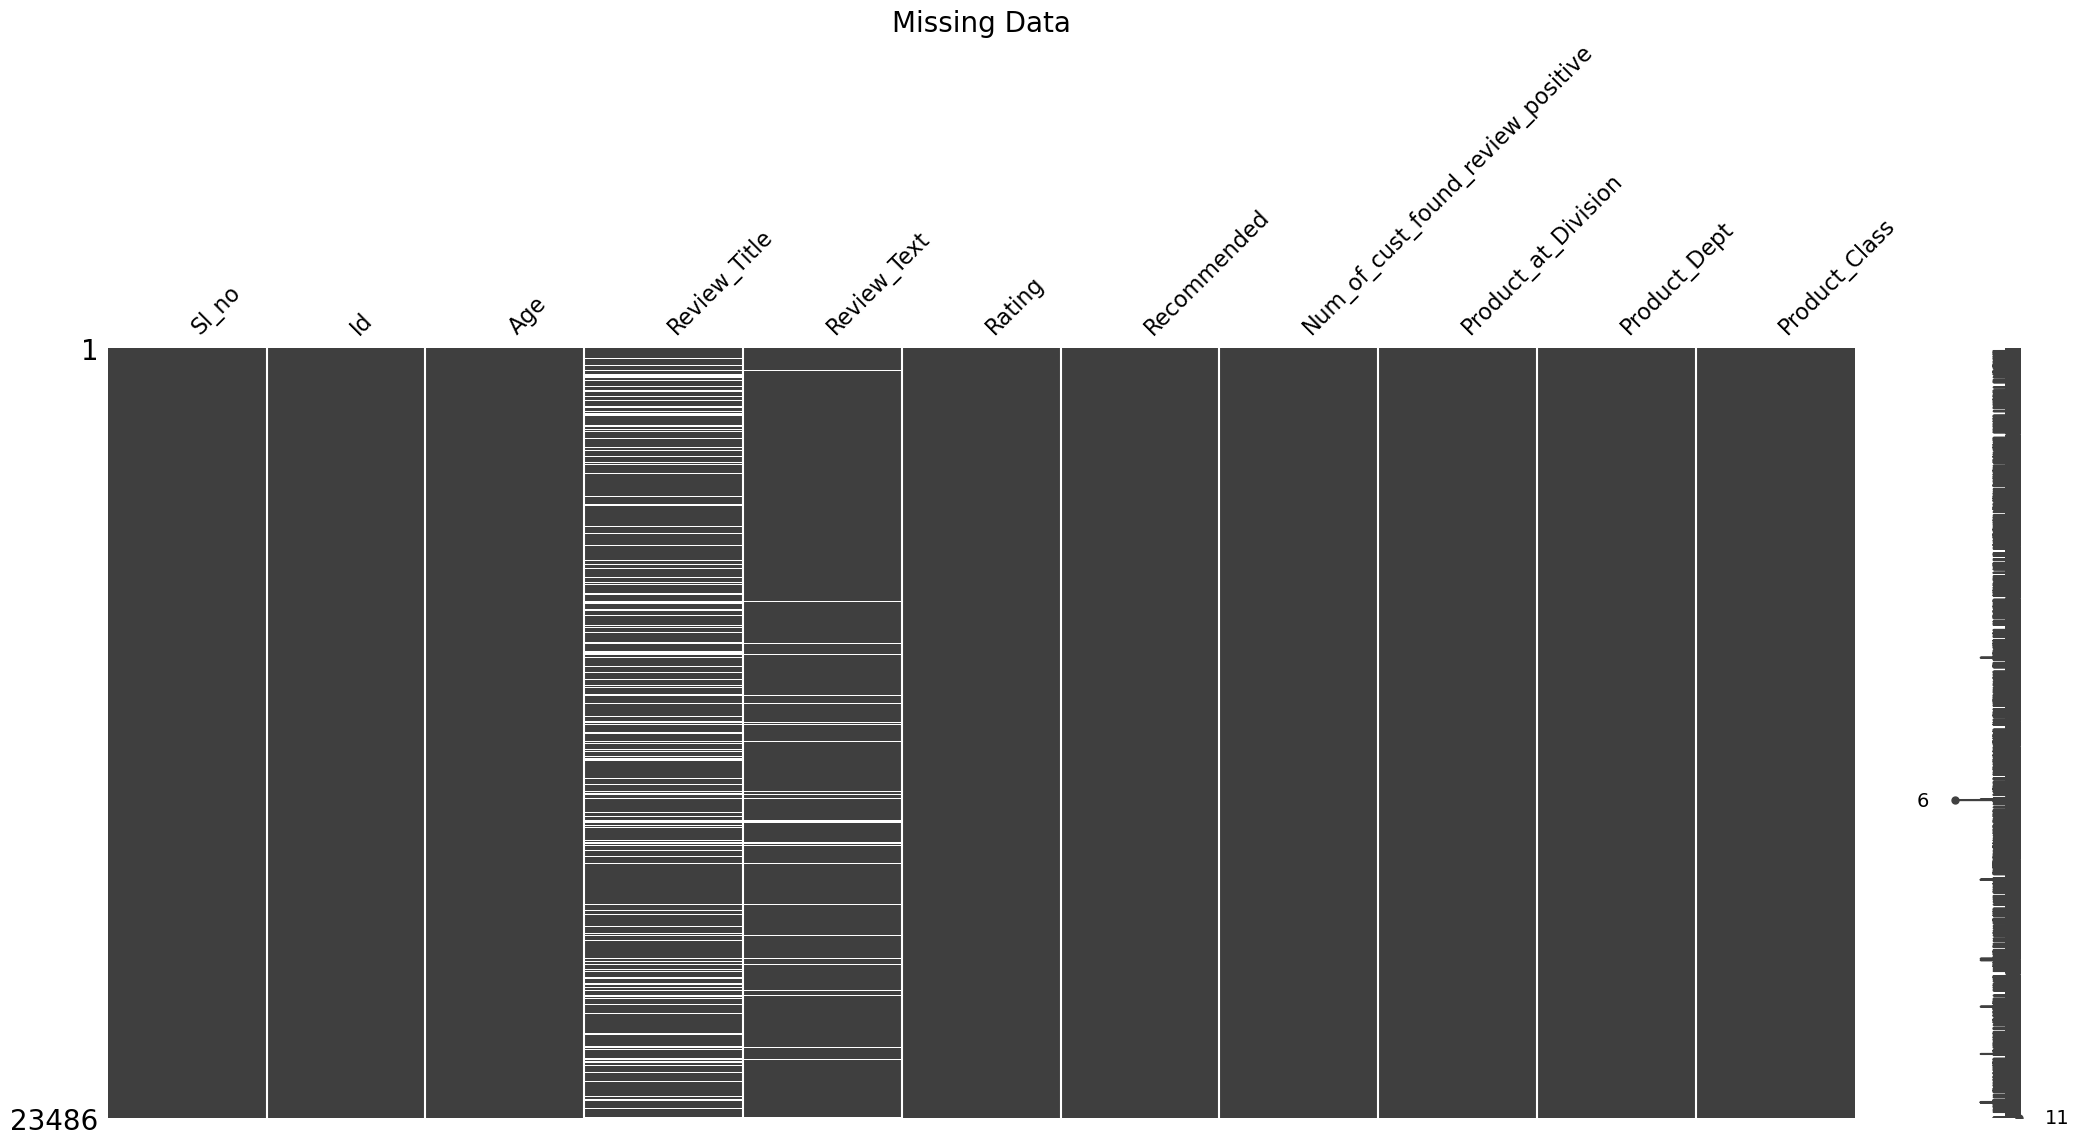

In [6]:
import missingno as msno
missing = msno.matrix(df)
missing.set_title("Missing Data", fontsize=20)

In [7]:
#Percentage missing values in each column
df.isnull().sum()/len(df)*100

Sl_no                                 0.000000
Id                                    0.000000
Age                                   0.000000
Review_Title                         16.222430
Review_Text                           3.597888
Rating                                0.000000
Recommended                           0.000000
Num_of_cust_found_review_positive     0.000000
Product_at_Division                   0.059610
Product_Dept                          0.059610
Product_Class                         0.059610
dtype: float64

Majority Missing values are present in Title and Review Text column

### Data Exploration

In [8]:
#Finding distribution of data in each column

for col in df.columns:
    uni = df[col].unique()
    uni_cnt = df[col].nunique()
    if len(uni) > 50:
        print(f"More than 50 unique values in {col}: {uni[0:3]}...")
    else:
        print(f"Unique values in {col}: {uni}")
    print(f"Total unique values in {col}: {uni_cnt}")
    print('-'*100)        
    

More than 50 unique values in Sl_no: [0 1 2]...
Total unique values in Sl_no: 23486
----------------------------------------------------------------------------------------------------
More than 50 unique values in Id: [ 767 1080 1077]...
Total unique values in Id: 1206
----------------------------------------------------------------------------------------------------
More than 50 unique values in Age: [33 34 60]...
Total unique values in Age: 77
----------------------------------------------------------------------------------------------------
More than 50 unique values in Review_Title: [nan 'Some major design flaws' 'My favorite buy!']...
Total unique values in Review_Title: 13993
----------------------------------------------------------------------------------------------------
More than 50 unique values in Review_Text: ['Absolutely wonderful - silky and sexy and comfortable'
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never 

We can assign Sentiment Classes to products with respect to Rating
- Ratings 1 and 2 indicate Negative Sentiment
- Rating 3 indicates Neutral Sentiment
- Rating 4 and 5 indicate Positive sentiment

In [9]:
#Assigning Rating based Sentiment

df['Rating_Sentiment'] = ""
ct = 0
for rating in df['Rating']:
    if rating > 3:
        df['Rating_Sentiment'][ct] = "Positive"
    elif rating == 3:
        df['Rating_Sentiment'][ct] = "Neutral"
    else:
        df['Rating_Sentiment'][ct] = "Negative"
    ct = ct + 1
        

In [10]:
df.head()

,Sl_no,Id,Age,Review_Title,Review_Text,Rating,Recommended,Num_of_cust_found_review_positive,Product_at_Division,Product_Dept,Product_Class,Rating_Sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Positive
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Neutral
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Positive


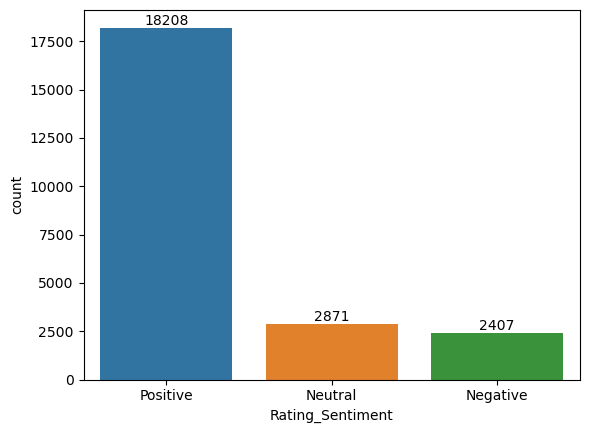

In [11]:
ax = sns.countplot(x = df['Rating_Sentiment'])
for i in ax.containers:
    ax.bar_label(i)

With this, we can say, that the dataset is imbalanced as there is a disproportionately high number of Positive reviews.

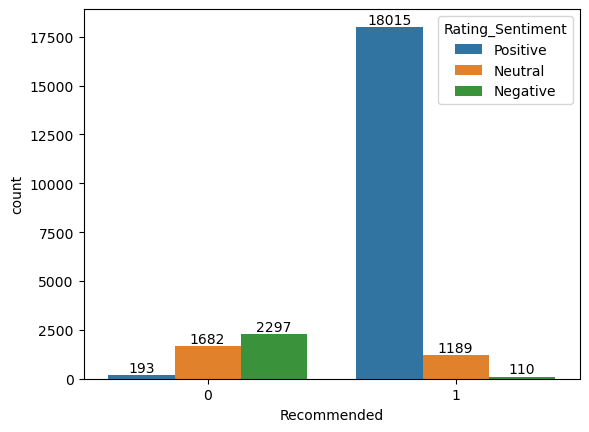

In [12]:
# Recommendation Indicator
ax = sns.countplot(x = df['Recommended'], hue = df['Rating_Sentiment'])
for i in ax.containers:
    ax.bar_label(i)

- Despite low rating, there are 110 products that have been recommended.
- Conversely, despite high rating, there are 193 products that have not been recommended.

<Axes: xlabel='Rating_Sentiment', ylabel='Age'>

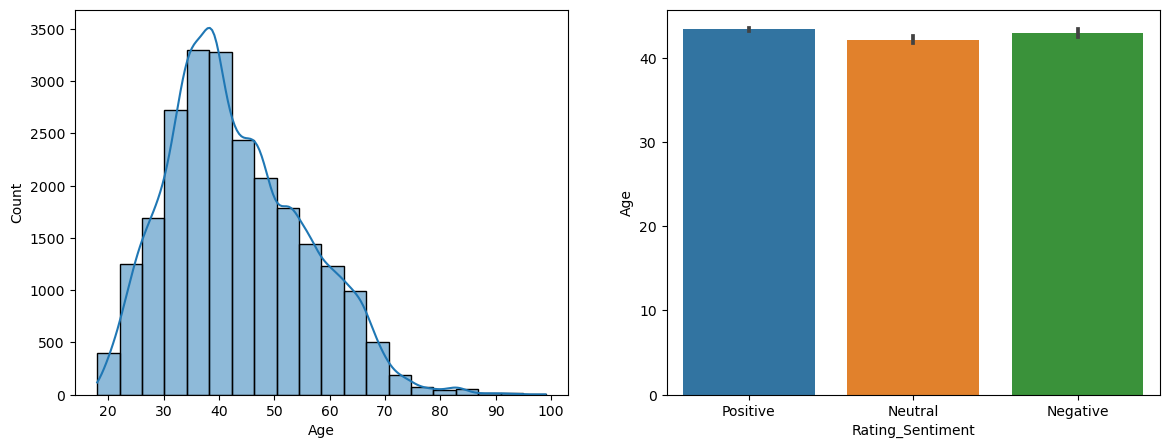

In [13]:
#Relationship between Age and Rating
f,axes = plt.subplots(1,2,figsize=(14,5))
sns.histplot(x = df['Age'], bins=20, kde=True, ax=axes[0])
sns.barplot(x = df['Rating_Sentiment'], y = df['Age'], ax=axes[1])


- The maximum age distribution lies between 20 and 70.
- The mean age is similar for all ratings. There is no discernable relationship between age and rating.

In [14]:
#Rating and Review positivity
x = df[(df['Rating']<3) & (df['Num_of_cust_found_review_positive']>0)]
len(df[(df['Rating']<3) & (df['Num_of_cust_found_review_positive']>0)])

1440

In [15]:
x['Recommended'].value_counts()

0    1379
1      61
Name: Recommended, dtype: int64

- There are 1440 customers who found even low rating reviews as positive. The column indicates helpfulness of a review and not positivity. 
- Inspite of low rating, 61 such products have been recommended.

In [16]:
#Renaming column
df = df.rename(columns = {'Num_of_cust_found_review_positive':'Num_of_cust_found_review_helpful'
                          })

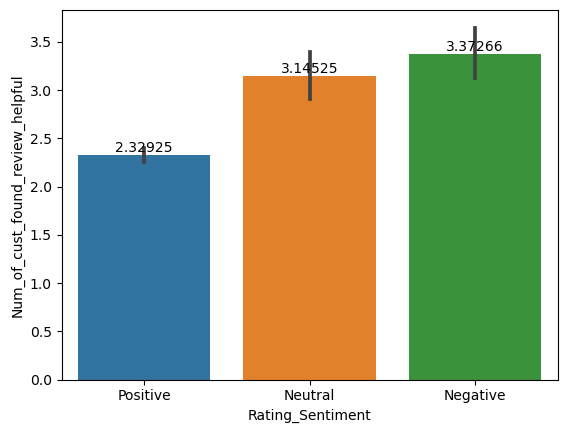

In [17]:
#Rating Sentiment and Helpfulness
ax = sns.barplot(x = df['Rating_Sentiment'], y = df['Num_of_cust_found_review_helpful'])
for i in ax.containers:
    ax.bar_label(i)

It can be seen that mean number of customers who found negative or neutral rating helpful is more than positive review.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Intimates'),
  Text(1, 0, 'Dresses'),
  Text(2, 0, 'Pants'),
  Text(3, 0, 'Blouses'),
  Text(4, 0, 'Knits'),
  Text(5, 0, 'Outerwear'),
  Text(6, 0, 'Lounge'),
  Text(7, 0, 'Sweaters'),
  Text(8, 0, 'Skirts'),
  Text(9, 0, 'Fine gauge'),
  Text(10, 0, 'Sleep'),
  Text(11, 0, 'Jackets'),
  Text(12, 0, 'Swim'),
  Text(13, 0, 'Trend'),
  Text(14, 0, 'Jeans'),
  Text(15, 0, 'Legwear'),
  Text(16, 0, 'Shorts'),
  Text(17, 0, 'Layering'),
  Text(18, 0, 'Casual bottoms'),
  Text(19, 0, 'Chemises')])

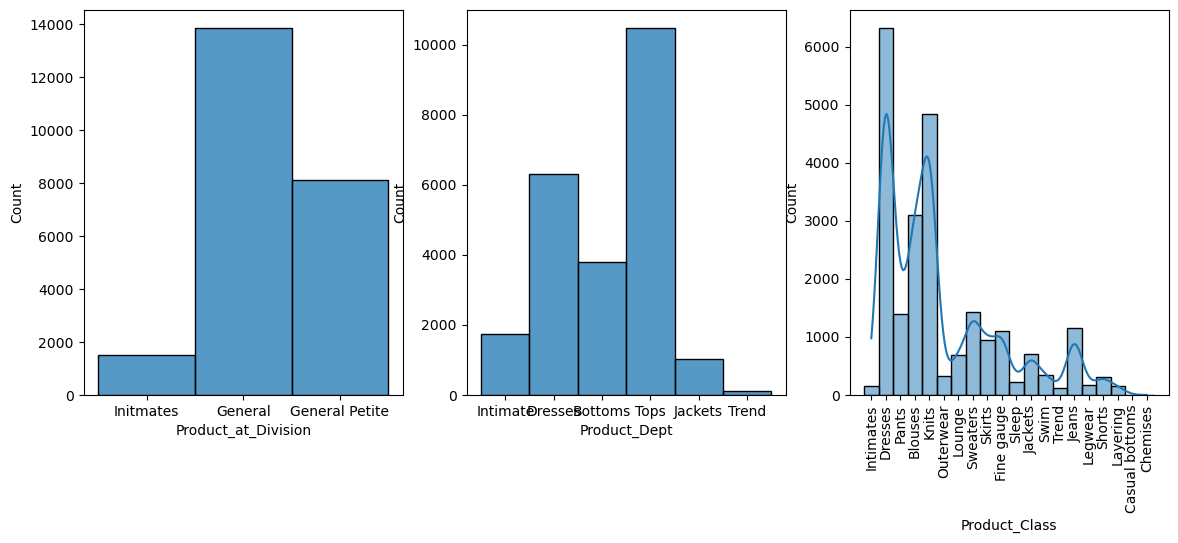

In [18]:
#Distribution of Products at Division, Department and CLass levels
f,axes = plt.subplots(1,3,figsize=(14,5))
sns.histplot(x = df['Product_at_Division'],ax=axes[0])
sns.histplot(x = df['Product_Dept'], ax=axes[1])
sns.histplot(x = df['Product_Class'], bins=20, kde=True, ax=axes[2])
plt.xticks(rotation=90)

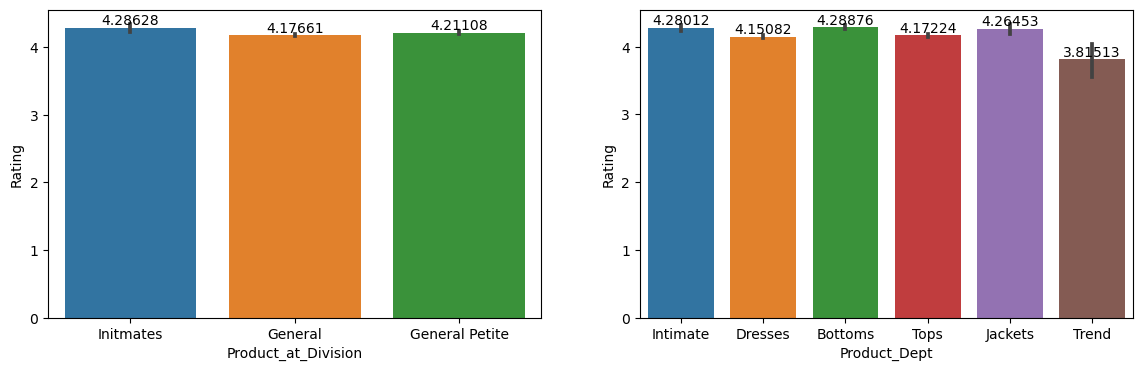

In [19]:
# Product and Rating relationship
f,axes = plt.subplots(1,2, figsize=(14,4))
ax = sns.barplot(x = df['Product_at_Division'], y = df['Rating'], ax=axes[0])
for i in ax.containers:
    ax.bar_label(i)
ax = sns.barplot(x = df['Product_Dept'], y = df['Rating'], ax=axes[1])
for i in ax.containers:
    ax.bar_label(i)

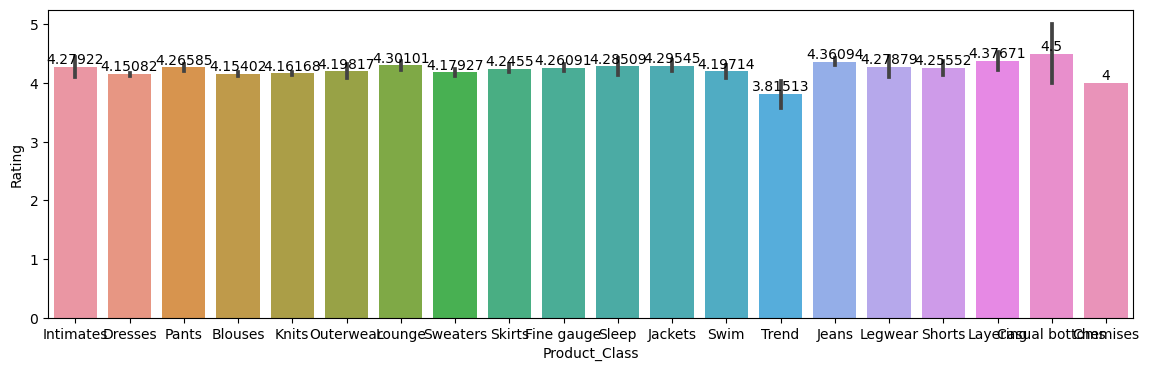

In [20]:
#Mean Rating and Product Class
plt.figure(figsize=(14,4))
ax = sns.barplot(x = df['Product_Class'], y = df['Rating'])
for i in ax.containers:
    ax.bar_label(i)

All products have a similar average mean rating except for Trend

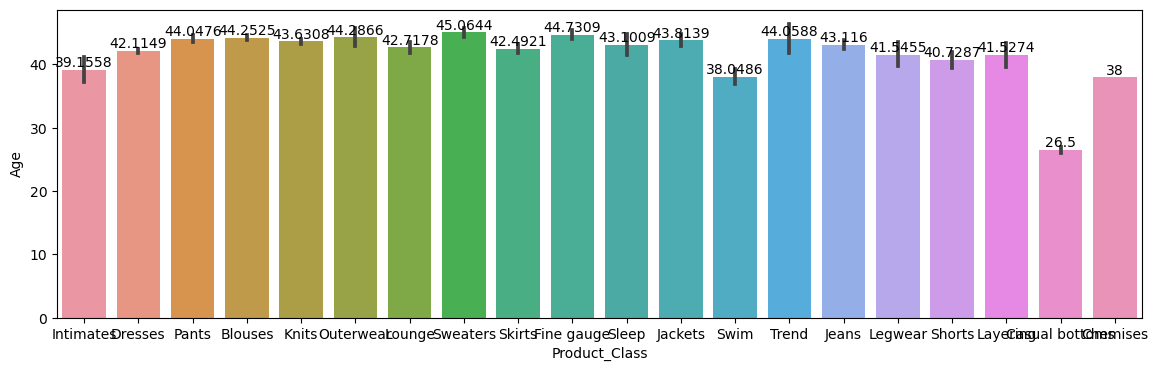

In [21]:
# Mean Age and Product Class
plt.figure(figsize=(14,4))
ax = sns.barplot(x = df['Product_Class'], y = df['Age'])
for i in ax.containers:
    ax.bar_label(i)

<Axes: xlabel='Id', ylabel='Count'>

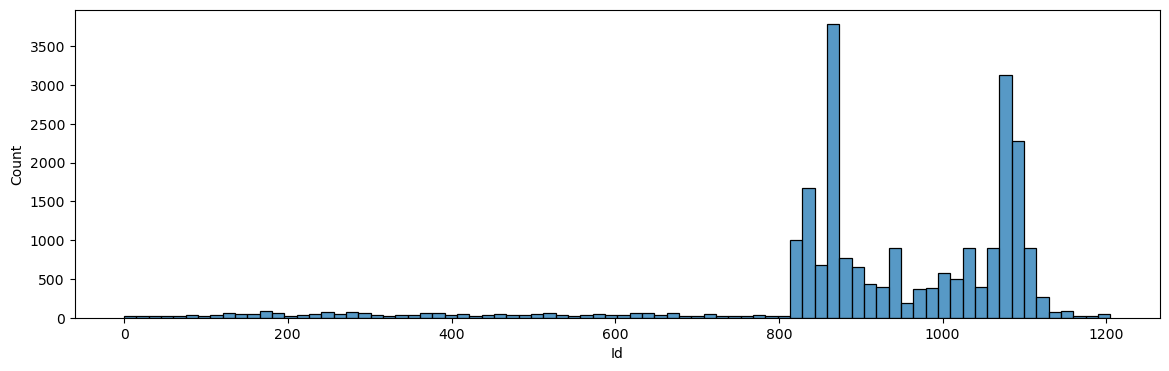

In [22]:
# Product Distribution as per ID
plt.figure(figsize=(14,4))
sns.histplot(x = df['Id'])

Product IDs between 800 and 1100 have mose reviews. 

In [23]:
#Finding Product Ids which have top 3 review count
id_list = list(df['Id'].unique())
id_count = []
for i in id_list:
    ct = len(df[(df['Id'] == i)])
    id_count.append(ct)
prod1 = list(zip(id_list, id_count))    

In [24]:
def top_value():   
    prod1.sort(key = lambda x: x[1], reverse=True) 
    return prod1[0][0], prod1[1][0], prod1[2][0]

val1, val2, val3 = top_value()
print(val1, val2, val3)

1078 862 1094


In [25]:
def top_value():   
    prod1.sort(key = lambda x: x[1], reverse=True) 
    return prod1[0][1], prod1[1][1], prod1[2][1]

val1, val2, val3 = top_value()
print(val1, val2, val3)

1024 806 756


### Treat Missing Values

In [26]:
df.isnull().sum()

Sl_no                                  0
Id                                     0
Age                                    0
Review_Title                        3810
Review_Text                          845
Rating                                 0
Recommended                            0
Num_of_cust_found_review_helpful       0
Product_at_Division                   14
Product_Dept                          14
Product_Class                         14
Rating_Sentiment                       0
dtype: int64

- Review_Title column will be dropped as it does not play any role in Sentiment Analysis
- The rest of the missing value rows will be dropped.

In [27]:
df1 = df.copy()

In [28]:
df1 = df1.drop(columns = ['Review_Title'])

In [29]:
df1 = df1.dropna()

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Sl_no                             22628 non-null  int64 
 1   Id                                22628 non-null  int64 
 2   Age                               22628 non-null  int64 
 3   Review_Text                       22628 non-null  object
 4   Rating                            22628 non-null  int64 
 5   Recommended                       22628 non-null  int64 
 6   Num_of_cust_found_review_helpful  22628 non-null  int64 
 7   Product_at_Division               22628 non-null  object
 8   Product_Dept                      22628 non-null  object
 9   Product_Class                     22628 non-null  object
 10  Rating_Sentiment                  22628 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.1+ MB


### Cleaning Review Text 

In [31]:
punctuation = list(string.punctuation)

stop_words = stopwords.words('english')

re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""

re_pattern = re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""

reviewText1 = [re.sub(pattern = re_pattern, string = text, repl="") 
               for text in df1.Review_Text.map(str).values]




In [32]:
reviewText1[100]

"The fabric felt cheap and i didn't find it to be a flattering top. for reference i am wearing a medium in the photos and my measurements are --."

In [33]:
#Removing stopwords and punctuation
review_data_cleaned = []

for review in reviewText1:
    # stop_words - NLTK
    stop_free = " ".join([txt for txt in review.lower().split() if txt not in stop_words])
    # STOPWORDS - WORDCLOUD
    stop_free_1 = " ".join([txt for txt in stop_free.lower().split() if txt not in STOPWORDS])
    
    puct_free = " ".join([txt for txt in stop_free_1.lower().split() if txt not in punctuation])
    review_data_cleaned.append(puct_free)

In [34]:
review_data_cleaned[1050]

'reviews sizing, ordered size (am normally size large). interestingly, tag blouse says said, blouse cute enough sizing gave enough length (in spite higher sides) considering keeping it. although bit big, flows nicely oversized wide, crazy way. sleeves bit big cuffed button rolled. fabric somewhat crinkled texture. got'

In [35]:
# remove hyphens, brackets and commas
review_data_cleaned_final = []
c = 0
for rdcf in review_data_cleaned:
    final_words = rdcf.replace("#",'')
    for p in punctuation:
        final_words = final_words.replace(p,'')
    review_data_cleaned_final.append(final_words)


In [36]:
review_data_cleaned_final[1080]

'usually wear size needed large ski flows beautifully'

In [37]:
# Lemmatization

wd = WordNetLemmatizer()

review_data_cleaned_final_output = []
for rdc in review_data_cleaned_final:
    clean_review = " ".join(wd.lemmatize(word) for word in rdc.split())
    review_data_cleaned_final_output.append(clean_review)

In [38]:
review_data_cleaned_final_output

['absolutely wonderful silky sexy comfoable',
 'love dress sooo pretty happened find store glad bc never ordered online bc petite bought petite love length me hit little knee definitely true midi someone truly petite',
 'high hope dress really wanted work me initially ordered petite small my usual size found outrageously small small fact zip up reordered petite medium ok overall top half comfoable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c',
 'love love love jumpsuit fun fliy fabulous every time wear it nothing great compliment',
 'shi flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shi',
 'love tracy reese dress one petite foot tall usually wear p brand dress pretty package lot dress ski long full overwhelmed small frame stranger alteration shoening narrowing ski take away embellishment garment love color idea style work me returned dress',
 'aded basket h

In [39]:
df1['clean_review'] = review_data_cleaned_final_output

In [40]:
df1.head()

,Sl_no,Id,Age,Review_Text,Rating,Recommended,Num_of_cust_found_review_helpful,Product_at_Division,Product_Dept,Product_Class,Rating_Sentiment,clean_review
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Positive,absolutely wonderful silky sexy comfoable
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Positive,love dress sooo pretty happened find store gla...
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Neutral,high hope dress really wanted work me initiall...
3,3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun fliy fabulous ever...
4,4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Positive,shi flattering due adjustable front tie perfec...


### Assigning sentiment using Sentiment Analyzer

In [41]:
# from vadar library import the required funtion
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [42]:
senti=SentimentIntensityAnalyzer()
senti

In [43]:
nltk.download('vader_lexicon')
  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [48]:
df1 = df1.reset_index()
df1.drop(columns = ['index'], inplace=True)

In [62]:
#Assigning sentiments using polarity scores
ct = 0
df1['Review_Sentiment'] = ""
df1['Sentiment_Avg_Score'] = 0
while(ct < (len(df1['clean_review']))):
    x = df1['clean_review'][ct].split()    
    score = 0
    for word in x:
        ind_score = senti.polarity_scores(word)['compound']
        score = score + ind_score
    avg_score = score / len(x)
    df1['Sentiment_Avg_Score'][ct] = avg_score
    if avg_score > 0.05:
        df1['Review_Sentiment'][ct] = 'Positive'
    elif avg_score <= 0.05 and avg_score>=0:
        df1['Review_Sentiment'][ct] ='Neutral'
    else:
        df1['Review_Sentiment'][ct] = 'Negative'
    ct = ct + 1

In [63]:
df1.head()

,Sl_no,Id,Age,Review_Text,Rating,Recommended,Num_of_cust_found_review_helpful,Product_at_Division,Product_Dept,Product_Class,Rating_Sentiment,clean_review,Review_Sentiment,Sentiment_Avg_Score
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Positive,absolutely wonderful silky sexy comfoable,Positive,0.219720
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Positive,love dress sooo pretty happened find store gla...,Positive,0.124654
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Neutral,high hope dress really wanted work me initiall...,Neutral,0.028886
3,3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun fliy fabulous ever...,Positive,0.289257
4,4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Positive,shi flattering due adjustable front tie perfec...,Positive,0.112513


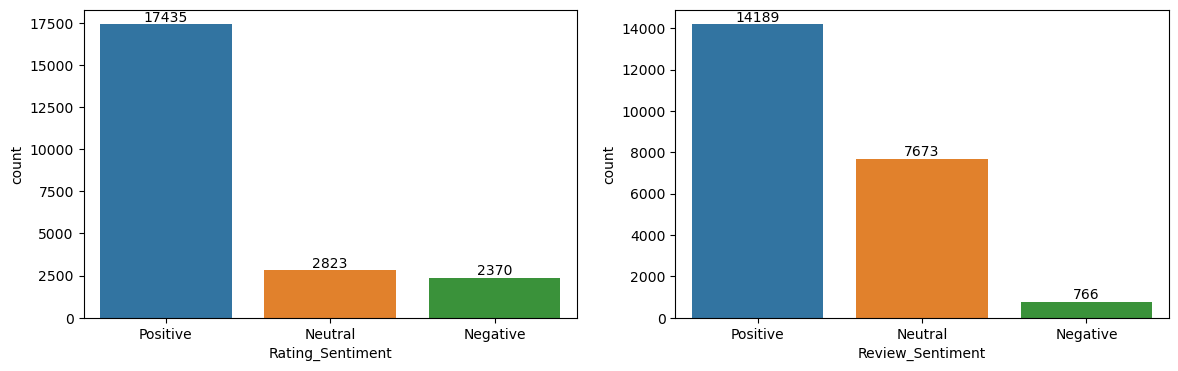

In [65]:
#Comparing Sentiments obtained from Ratings and SentimentAnalyzer
f,axes = plt.subplots(1,2, figsize=(14,4))
ax = sns.countplot(x = df1['Rating_Sentiment'], ax=axes[0])
for i in ax.containers:
    ax.bar_label(i)
ax = sns.countplot(x = df1['Review_Sentiment'], ax=axes[1])
for i in ax.containers:
    ax.bar_label(i)

In [72]:
print(f"Difference in Positive sentiment outputs : {len(df1[(df1['Rating_Sentiment'] == 'Positive') & (df1['Review_Sentiment']!='Positive')])}")
print(f"Difference in Neutral sentiment outputs : {len(df1[(df1['Rating_Sentiment'] == 'Neutral') & (df1['Review_Sentiment']!='Neutral')])}")
print(f"Difference in Negative sentiment outputs : {len(df1[(df1['Rating_Sentiment'] == 'Negative') & (df1['Review_Sentiment']!='Negative')])}")

Difference in Positive sentiment outputs : 5057
Difference in Neutral sentiment outputs : 1333
Difference in Negative sentiment outputs : 2004


Using Sentiment Analyzer, it can be seen that 
- Neutral Sentiment is much higher than rating sentiment
- Negative sentiment is much lower than rating sentiment
- Positive sentiment is also slightly lower than rating sentiment

I have used polarity scores to calculate the sentiment through sentiment analyser which can be ambiguous because I have used 0.05 as the threshold to distinguish between Positive and Neutral sentiments. The results will vary for different threshold. This method can also be considered to assign sentiments for texts.

However, as I wish to build supervised machine learning models to predict sentiments, I need sentiment as a target variable. Since target variable was not given at with the problem statement, I choose the sentiment obtained through user ratings as my target variable.

### Removing insignificant columns



In [68]:
df1.drop(columns = ['Sl_no', 'Id', 'Age','Recommended',
       'Num_of_cust_found_review_helpful', 'Product_at_Division',
       'Product_Dept', 'Product_Class'], inplace=True)

### Analysis using WordCloud

In [73]:
positive_review = df1[df1['Rating_Sentiment']=='Positive']['clean_review']
negative_review = df1[df1['Rating_Sentiment']=='Negative']['clean_review']
neutral_review = df1[df1['Rating_Sentiment']=='Neutral']['clean_review']

In [74]:
positive_review.shape, negative_review.shape, neutral_review.shape

((17435,), (2370,), (2823,))

In [75]:
pos_data_token = [nltk.word_tokenize(rvw) for rvw in positive_review]
neg_data_token = [nltk.word_tokenize(rvw) for rvw in negative_review]
neu_data_token = [nltk.word_tokenize(rvw) for rvw in neutral_review]

In [76]:
print(neu_data_token)

[['high', 'hope', 'dress', 'really', 'wanted', 'work', 'me', 'initially', 'ordered', 'petite', 'small', 'my', 'usual', 'size', 'found', 'outrageously', 'small', 'small', 'fact', 'zip', 'up', 'reordered', 'petite', 'medium', 'ok', 'overall', 'top', 'half', 'comfoable', 'fit', 'nicely', 'bottom', 'half', 'tight', 'layer', 'several', 'somewhat', 'cheap', 'net', 'layer', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directly', 'zipper', 'c'], ['dress', 'run', 'small', 'esp', 'zipper', 'area', 'run', 'ordered', 'sp', 'typically', 'fit', 'tight', 'material', 'top', 'look', 'feel', 'cheap', 'even', 'pulling', 'cause', 'rip', 'fabric', 'pretty', 'disappointed', 'going', 'christmas', 'dress', 'year', 'needle', 'say', 'going', 'back'], ['nice', 'choice', 'holiday', 'gathering', 'length', 'graz', 'knee', 'conservative', 'enough', 'office', 'related', 'gathering', 'size', 'small', 'fit', 'well', 'usually', 'size', 'small', 'bust', 'opinion', 'run', 'small', 'larger', 'bust', 'definite

In [78]:
wordcloud_pos = WordCloud(background_color='white', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(pos_data_token))

wordcloud_neg = WordCloud(background_color='black', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neg_data_token))

wordcloud_neu = WordCloud(background_color='grey', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neu_data_token))

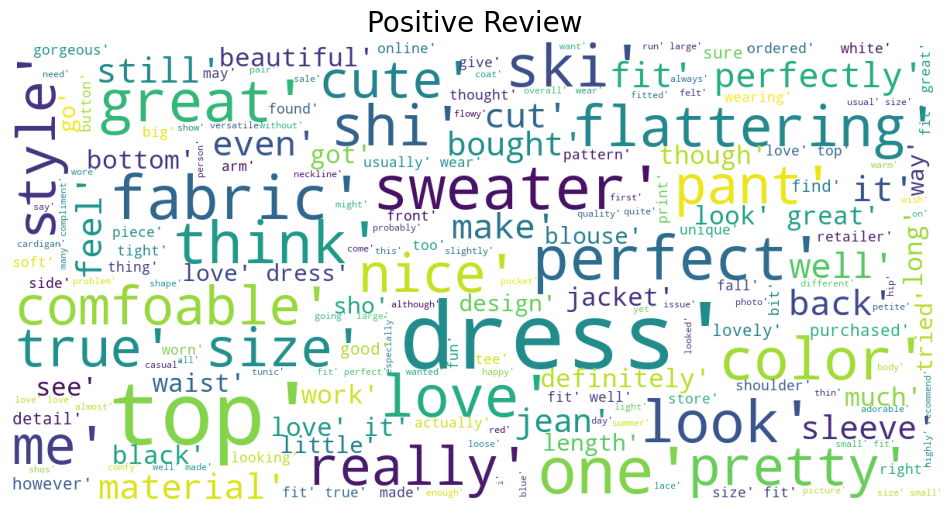

In [79]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_pos)
plt.title("Positive Review", size=20)
plt.show()

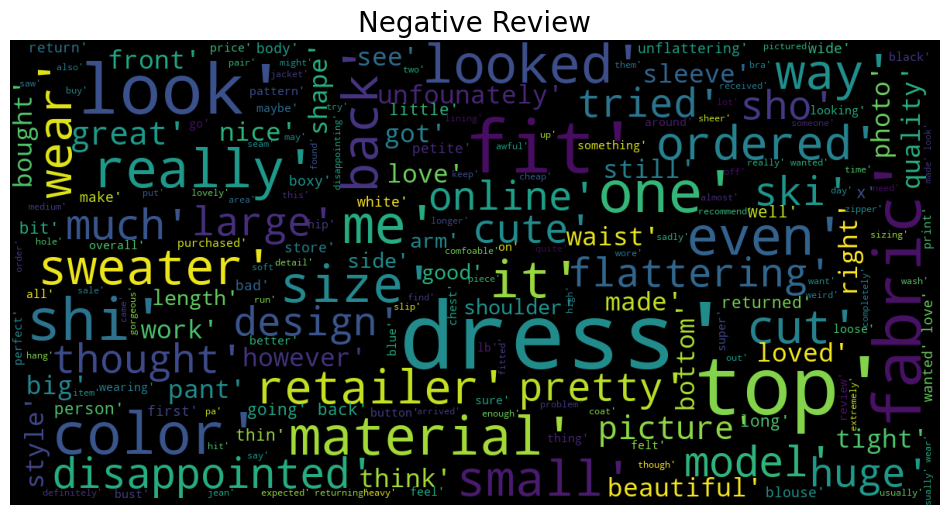

In [80]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neg)
plt.title("Negative Review", size=20)
plt.show()

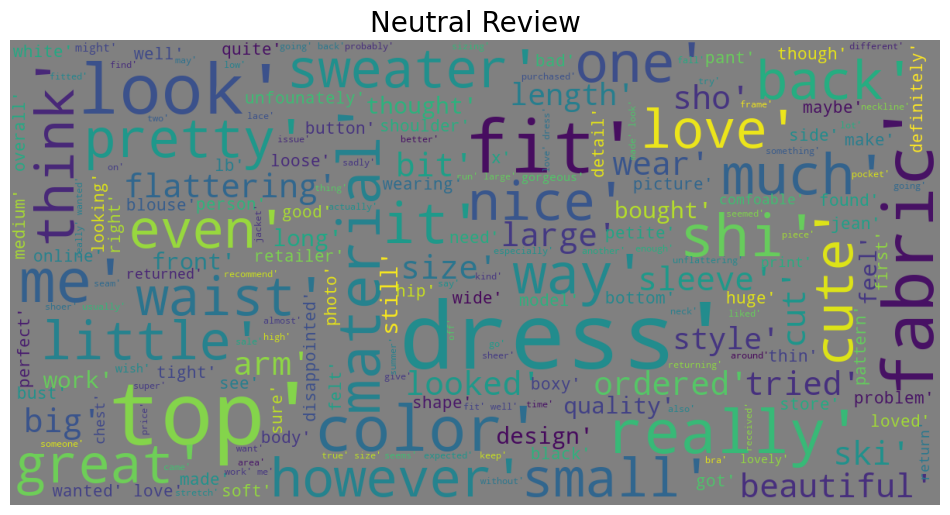

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neu)
plt.title("Neutral Review", size=20)
plt.show()

The most frequently used words are being displayed as per sentiment given. 

### Splitting dataset for model building

In [82]:
# split the data into training and test

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df1['clean_review'],
                                                df1['Rating_Sentiment'],test_size=0.2,
                                                   random_state=23,
                                                   stratify=df1['Rating_Sentiment'])

### Feature Extraction using TF-IDF vectorizer 

In [83]:
# vectorize the text data using TfidfVectorizer
tf_idf = TfidfVectorizer().fit(x_train)
x_train_tf_idf = tf_idf.transform(x_train)
x_test_tf_idf = tf_idf.transform(x_test)

In [84]:
pd.DataFrame(x_test_tf_idf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,14999,15000,15001,15002,15003,15004,15005,15006,15007,15008
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Model Building

- MultinomialNB
- RandomForestClassifier
- XGBClassifier


#### MultinomialNB

In [85]:
naive_bayes_multi = MultinomialNB().fit(x_train_tf_idf, y_train)

In [87]:
print(naive_bayes_multi.score(x_train_tf_idf, y_train))
print()
print(naive_bayes_multi.score(x_test_tf_idf, y_test))

0.7727322947740581

0.770437472381794


In [88]:
def get_num(data):
    data_new = pd.DataFrame(data, columns=['Rating_Sentiment'])
    data_new['y_label'] = np.where(data_new['Rating_Sentiment']=='Neutral',0,
                                  np.where(data_new['Rating_Sentiment']=='Positive',1,2))
    return data_new

In [90]:
predict_train = naive_bayes_multi.predict(x_train_tf_idf)
predict_test = naive_bayes_multi.predict(x_test_tf_idf)

In [91]:
y_train_new = get_num(y_train)
y_test_new = get_num(y_test)
predict_train_new = get_num(predict_train)
predict_test_new = get_num(predict_test)

In [92]:
print(classification_report(y_train_new['y_label'],predict_train_new['y_label'] ))
print()
print(classification_report(y_test_new['y_label'],predict_test_new['y_label'] ))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2258
           1       0.77      1.00      0.87     13948
           2       0.97      0.02      0.04      1896

    accuracy                           0.77     18102
   macro avg       0.92      0.34      0.30     18102
weighted avg       0.82      0.77      0.68     18102


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       565
           1       0.77      1.00      0.87      3487
           2       0.00      0.00      0.00       474

    accuracy                           0.77      4526
   macro avg       0.26      0.33      0.29      4526
weighted avg       0.59      0.77      0.67      4526



#### Random Forest Classifier

In [93]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf, y_train)

In [94]:
print(rf_model.score(x_train_tf_idf, y_train))
print()
print(rf_model.score(x_test_tf_idf, y_test))

1.0

0.7834732655766682


In [95]:
predict_train1 = rf_model.predict(x_train_tf_idf)
predict_test1 = rf_model.predict(x_test_tf_idf)

In [96]:
y_train_new1 = get_num(y_train)
y_test_new1 = get_num(y_test)
predict_train_new1 = get_num(predict_train1)
predict_test_new1 = get_num(predict_test1)

In [97]:
print(classification_report(y_train_new1['y_label'],predict_train_new1['y_label'] ))
print()
print(classification_report(y_test_new1['y_label'],predict_test_new1['y_label'] ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2258
           1       1.00      1.00      1.00     13948
           2       1.00      1.00      1.00      1896

    accuracy                           1.00     18102
   macro avg       1.00      1.00      1.00     18102
weighted avg       1.00      1.00      1.00     18102


              precision    recall  f1-score   support

           0       0.58      0.01      0.02       565
           1       0.79      1.00      0.88      3487
           2       0.70      0.12      0.20       474

    accuracy                           0.78      4526
   macro avg       0.69      0.38      0.37      4526
weighted avg       0.75      0.78      0.70      4526



In [98]:
print(accuracy_score(y_train_new1['y_label'],predict_train_new1['y_label'] ))
print()
print(accuracy_score(y_test_new1['y_label'],predict_test_new1['y_label'] ))

1.0

0.7834732655766682


Clear case of overfitting

#### XG Boost Classifier

In [99]:
y_train_new2 = get_num(y_train)
y_test_new2 = get_num(y_test)

In [101]:
xgboost = XGBClassifier().fit(x_train_tf_idf, y_train_new2['y_label'])

In [103]:
print(xgboost.score(x_train_tf_idf, y_train_new2['y_label']))
print()
print(xgboost.score(x_test_tf_idf, y_test_new2['y_label']))

0.9245387250027621

0.805346884666372


Some level of overfitting is present

### Applying K-fold Cross Validation

In [104]:
from sklearn.model_selection import cross_val_score
training_accuracy = cross_val_score(xgboost, x_train_tf_idf, y_train_new2['y_label'], cv=10)
print(training_accuracy.mean())

0.8112367636695333


XG Boost Classifier is the best performing model with an accuracy of 80%. 

### Conclusion

In conclusion, XGBoost Classifier is performing the best for predicting the sentiment. On completely unknown data, our model can predict with an accuracy of 70% - 75%.